In [2]:
from tqdm.notebook import tqdm
from fetcher import fetch_difumo
import numpy as np
from nilearn.maskers import NiftiMapsMasker
import dask.array as da
from dask import delayed
import nibabel as nib
from dask.distributed import Client, LocalCluster
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds

## Get ROI Timeseries

In [4]:
num_frames = 290

In [3]:
difumo_dim = 64
maps_img = fetch_difumo(dimension=difumo_dim).maps
maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=0, standardize=True)

In [4]:
labels = ['Superior frontal sulcus', 'Fusiform gyrus', 'Calcarine cortex posterior', 'Cingulate cortex posterior', 
          'Parieto-occipital sulcus superior', 'Insula antero-superior', 
          'Superior temporal sulcus with angular gyrus', 
          'Planum temporale', 'Cerebellum Crus II', 'Superior parts of Postcentral and Precentral gyri', 
          'Transverse sinus', 'Paracentral gyrus RH', 'Superior occipital gyrus', 'Cingulate gyrus mid-posterior', 
          'ventricles', 'Fusiform gyrus posterior', 'Superior frontal gyrus medial', 'Precuneus superior', 
          'Planum polare', 'Parieto-occipital sulcus middle', 'Cerebellum I-V', 'Superior fornix and isthmus', 
          'Anterior Cingulate Cortex', 'Descending occipital gyrus', 'Putamen', 'Cingulate gyrus mid-anterior', 
          'Superior parietal lobule posterior', 'Paracentral lobule', 'Inferior occipital gyrus', 
          'Superior rostral gyrus', 'Calcarine sulcus anterior', 'Intraparietal sulcus', 
          'Superior parietal lobule anterior', 'Precentral gyrus medial', 'Lingual gyrus anterior', 
          'Angular gyrus superior', 'Supramarginal gyrus', 'Intraparietal sulcus LH', 
          'Dorsomedial prefrontal cortex antero-superior', 'Precentral gyrus superior', 
          'Postcentral gyrus inferior', 'Lateral occipital cortex', 'Callosomarginal sulcus', 
          'Paracentral lobule superior', 'Heschl‚Äôs gyrus', 'Occipital pole', 'Thalamus', 'Intraparietal sulcus RH', 
          'Inferior frontal sulcus', 'Postcentral gyrus LH', 'Middle frontal gyrus', 'Inferior frontal gyrus', 
          'Parieto-occipital sulcus anterior', 'Precuneus anterior', 'Lingual gyrus', 'Superior occipital sulcus', 
          'Superior parietal lobule', 'Middle frontal gyrus anterior', 'Angular gyrus inferior', 'Cuneus', 
          'Middle temporal gyrus', 'Superior frontal gyrus', 'Central sulcus', 'Caudate']

In [5]:
all_sub_time_series = []
subjs = []

for sub in tqdm(range(1, 101), desc='Subjects'):
    bold_fname = f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    try:
        nib.load(bold_fname)  # Check if we have access to the file
    except FileNotFoundError:
        print(f'Error for {sub}')
        continue
    
    confounds_minimal_no_gsr, sample_mask = load_confounds(
        bold_fname,
        strategy=["high_pass", "motion", "wm_csf", "global_signal"],
        motion="basic", wm_csf="basic", global_signal="basic")

    time_series = maps_masker.fit_transform(bold_fname, confounds=confounds_minimal_no_gsr,
                                            sample_mask=sample_mask)
    if time_series.shape[0] != num_frames:
        print(f'Dimension issue for {sub}')
        continue
    
    all_sub_time_series.append(time_series)
    subjs.append(sub)

stacked_sub_time_series = np.stack(all_sub_time_series, axis=0)


Subjects:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension issue for 8
Error for 9
Error for 19
Error for 20
Error for 21
Error for 22
Error for 23
Error for 24
Error for 25
Error for 26
Error for 27
Error for 28
Error for 29
Error for 30
Error for 31
Error for 32
Error for 33
Error for 34
Error for 35
Error for 36
Error for 37
Error for 38
Error for 39
Error for 40
Error for 41
Error for 42
Error for 43
Error for 44
Error for 45
Error for 46
Error for 47
Error for 48
Error for 49
Error for 50
Error for 51
Error for 52
Error for 53
Error for 54
Error for 55
Error for 56
Error for 57
Error for 58
Error for 59
Error for 60
Error for 61
Error for 62
Error for 63
Error for 64
Error for 65
Error for 66
Error for 67
Error for 68
Error for 69
Error for 70
Error for 71
Error for 72
Error for 73
Error for 74
Error for 75
Error for 76
Error for 77
Error for 78
Error for 79
Error for 80
Error for 81
Error for 82
Error for 83
Error for 84
Error for 85
Error for 86
Error for 87
Error for 88
Error for 89
Error for 90
Error for 91
Error for 92
Erro

In [6]:
num_subjects = len(all_sub_time_series)
num_subjects

16

In [7]:
stacked_sub_time_series.shape

(16, 290, 64)

## Connectivity Measure

In [8]:
correlation_measure = ConnectivityMeasure(kind='correlation')

In [9]:
correlation_matrix = correlation_measure.fit_transform(stacked_sub_time_series)

In [10]:
correlation_matrix.shape

(16, 64, 64)

In [11]:
one_corr = correlation_matrix[0]
one_corr.shape

(64, 64)

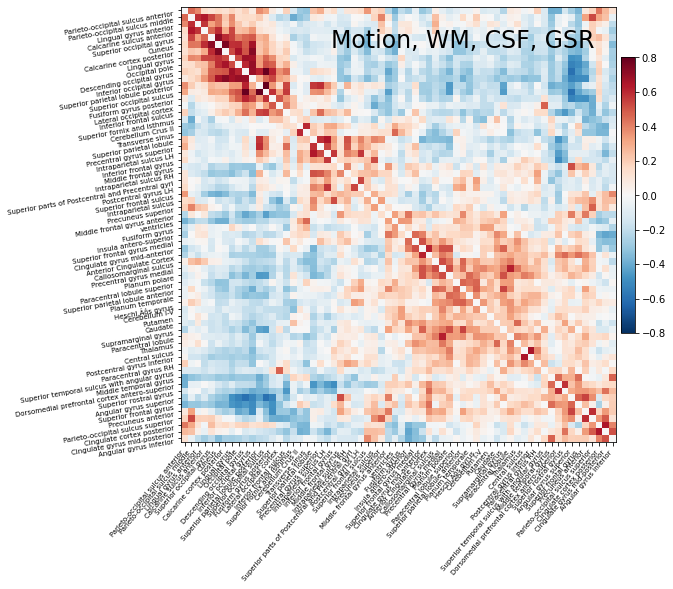

In [12]:
# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(one_corr, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(one_corr, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, title='Motion, WM, CSF, GSR',
                     reorder=True)

## Windowed Correlation Measure

In [5]:
sliding = 2
window_length = 10

correlation_matrices = []
for start_time in tqdm(range(0, num_frames, sliding)):
    if start_time + window_length > num_frames:
        continue

    window_data = stacked_sub_time_series[:, start_time:start_time+window_length, :]
    correlation_matrix = correlation_measure.fit_transform(window_data)
    correlation_matrices.append(correlation_matrix)
    
windowed_cms = np.stack(correlation_matrices, axis=1)

  0%|          | 0/145 [00:00<?, ?it/s]

0 10


NameError: name 'stacked_sub_time_series' is not defined

In [18]:
windowed_cms.shape

(16, 141, 64, 64)

In [19]:
with open('windowed_cms.npy', 'wb') as f:
    np.save(f, windowed_cms)

## Parallelise work

In [16]:
def parallel_work():
    cluster = LocalCluster()
    client = Client(cluster)

    difumo_dim = 64
    maps_img = fetch_difumo(dimension=difumo_dim).maps
    maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=0, standardize=True)

    subjects_fmri = []

    for sub in range(1, 101):
        fname = f'/home/jovyan/shared/ds003097/derivatives/fmriprep/sub-{sub:04}/func/sub-{sub:04}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
        try: 
            subjects_fmri.append(nib.load(fname))
        except:
            print(f'Error for {sub}')

    num_subjects_data = len(subjects_fmri)


    num_frames = 290
    signals_list_delayed = []

    def process_time_slice(frame_num):
        maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=0, standardize=True)
        all_subs_frame = []
        for sub_fmri in subjects_fmri:
            time_slice = sub_fmri.slicer[:, :, :, frame_num]
            all_subs_frame.append(time_slice)
        signals = maps_masker.fit_transform(all_subs_frame)
        return signals

    process_time_slice_delayed = delayed(process_time_slice)

    for frame_n in range(num_frames):
        signals_list_delayed.append(
            da.from_delayed(
                process_time_slice_delayed(frame_n), 
                (num_subjects_data, difumo_dim), 
                dtype=float
            )
        )

    all_signals = da.stack(signals_list_delayed, 0)

    # all_signals.visualize(filename='all_signals.svg')
    # result = all_signals.compute()
    my_result = client.compute(all_signals)
    result = client.gather(my_result)
    return result
